# DSCOVR EPIC Image Processing

This is an overview on how to get started processing the raw data from the EPIC sensor on the DSCOVR satellite using Python.

We're processing the "Level 1B" data from EPIC here, which contains calibrated and georeferenced data so we don't have to attempt to align the individual per-band images.

You'll have to get the data yourself by ordering it from [here](https://search.earthdata.nasa.gov/search/granules?p=C1282024672-LARC_ASDC&m=0!-156.31940000000003!0!1!0!0%2C2&tl=1452723879!4!!&q=DSCOVR). The raw files are about 175MB each.

In [3]:
%pylab inline
%matplotlib inline
from ipy_table import *
import h5py
import numpy as np
import scipy.ndimage
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
h5py.enable_ipython_completer()

img = h5py.File('epic_1b_20160921201548_01.h5')

Populating the interactive namespace from numpy and matplotlib


The data is provided as an HDF5 file which contains all the individual images, and has an internal structure which provides metadata. NASA provides [some documentation](https://eosweb.larc.nasa.gov/project/dscovr/EPIC_Data_Format_Control_Book_2016-07-01.pdf) on the structure.

We can list the "groups" within this file, which correspond to the individual images from the sensor:

In [11]:
list(img)

['Band317nm',
 'Band325nm',
 'Band340nm',
 'Band388nm',
 'Band443nm',
 'Band551nm',
 'Band680nm',
 'Band688nm',
 'Band764nm',
 'Band780nm']

Within the group for each band, we have the raw image data, as well as some geolocation data:

In [7]:
list(img['Band317nm'])

['Geolocation', 'Image']

We can take a look at the attributes for the geolocation data with regards to Earth, which contains some useful info (if the moon is in the frame, there will be a `Moon` group as well):

In [6]:
make_table([("Attribute", "Value")] + list(img['Band317nm']['Geolocation']['Earth'].attrs.items()))

Attribute,Value
image_band,[9]
earth_north_direction,[-66.42248881]
centroid_equatorial_pixel_size,[ 1583.91174316]
centroid_polar_pixel_size,[ 1578.60119629]
dscovr_ephemeris_x_position,[-1511700.]
dscovr_ephemeris_y_position,[ 252084.1875]
dscovr_ephemeris_z_position,[ 111630.8515625]
dscovr_ephemeris_x_velocity,[-0.02583]
dscovr_ephemeris_y_velocity,[-0.26062]
dscovr_ephemeris_z_velocity,[-0.0374]


Let's take a look at the individual per-band images for this dataset:

/usr/local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


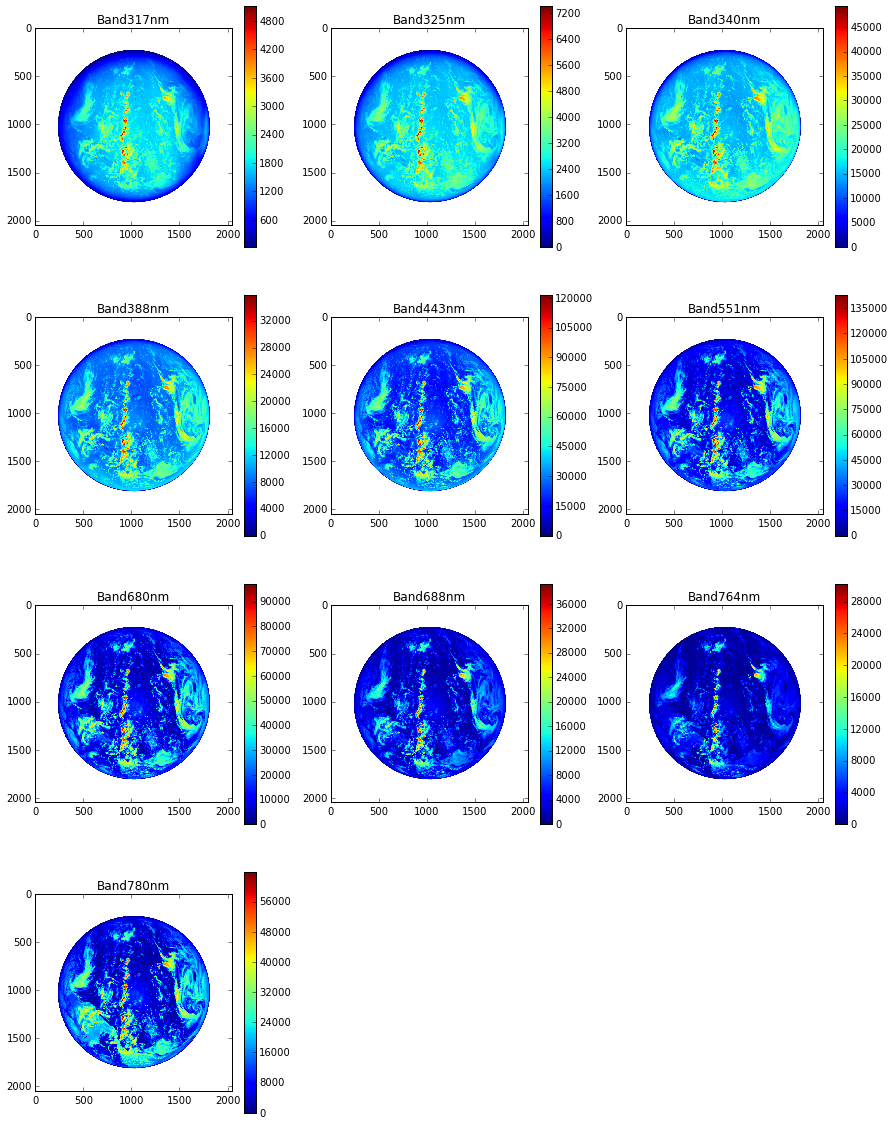

In [13]:
figsize(15, 25)

fig = plt.figure()

i = 1
for band in img:
    a = fig.add_subplot(5, 3, i)
    plt.imshow(img[band]['Image'])
    plt.colorbar()
    a.set_title(band)
    i += 1
    
plt.show()

We can see that the values of individual pixels vary quite wildly (due, presumably, to the absorbtion of the filters and the sensitivity of the sensor. We can plot individual histograms:

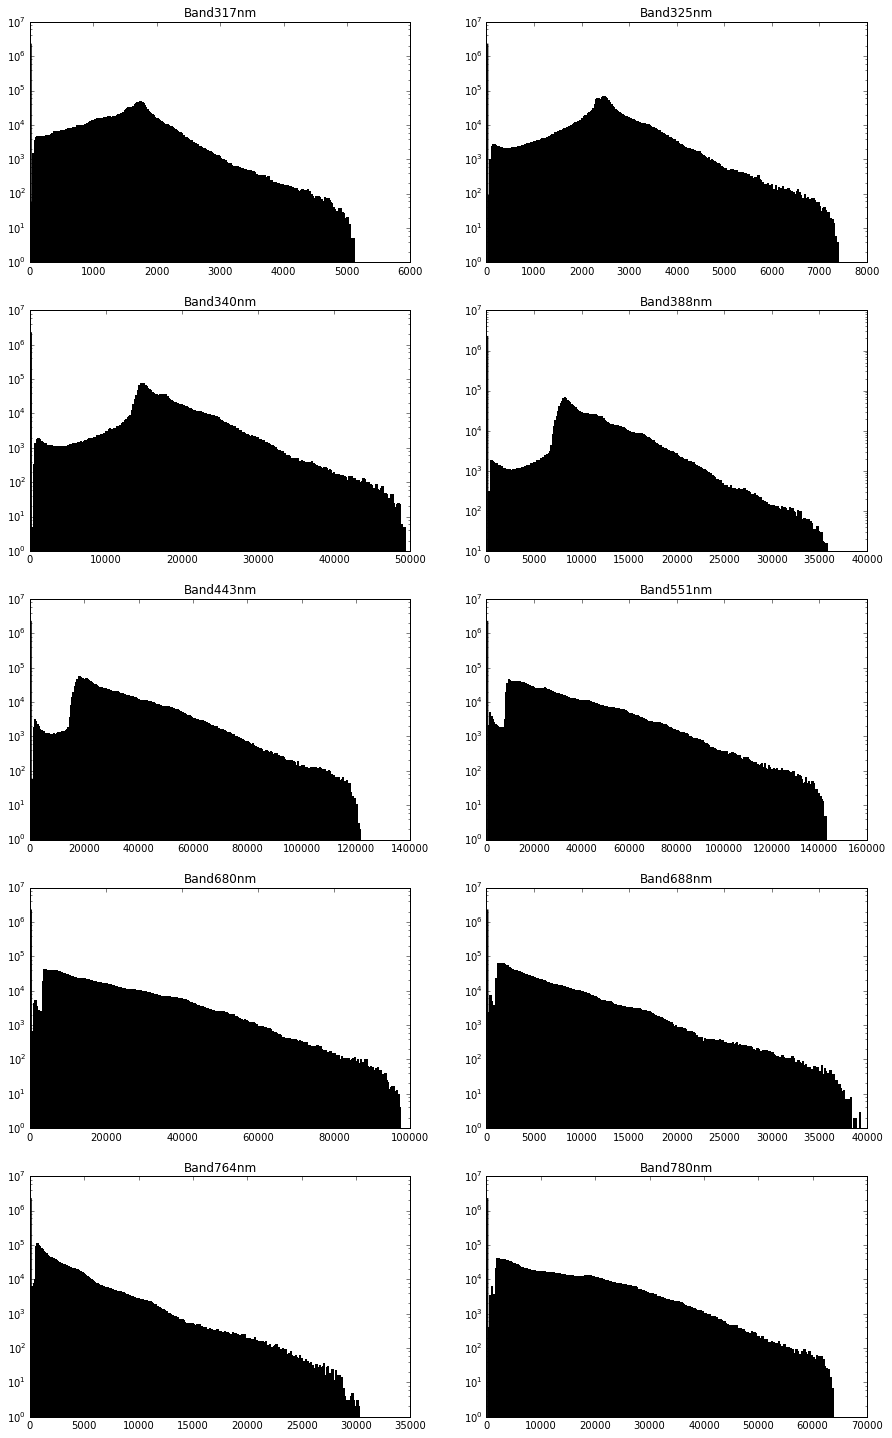

In [31]:
figsize(15, 25)

fig = plt.figure()

i = 1
for band in img:
    a = fig.add_subplot(5, 2, i)
    arr = numpy.ma.fix_invalid(np.array(img[band]['Image']), fill_value=0)
    plt.yscale('log', nonposy='clip')
    plt.hist(arr.ravel(), bins=256, fc='k', ec='k')
    a.set_title(band)
    i += 1
    
plt.show()

Now we'll try and put together a simple RGB image. We pick the bands which are closest to the middle of the visible colour ranges, rotate them so north is up, stack them into a RGB image, and apply a bit of image processing:

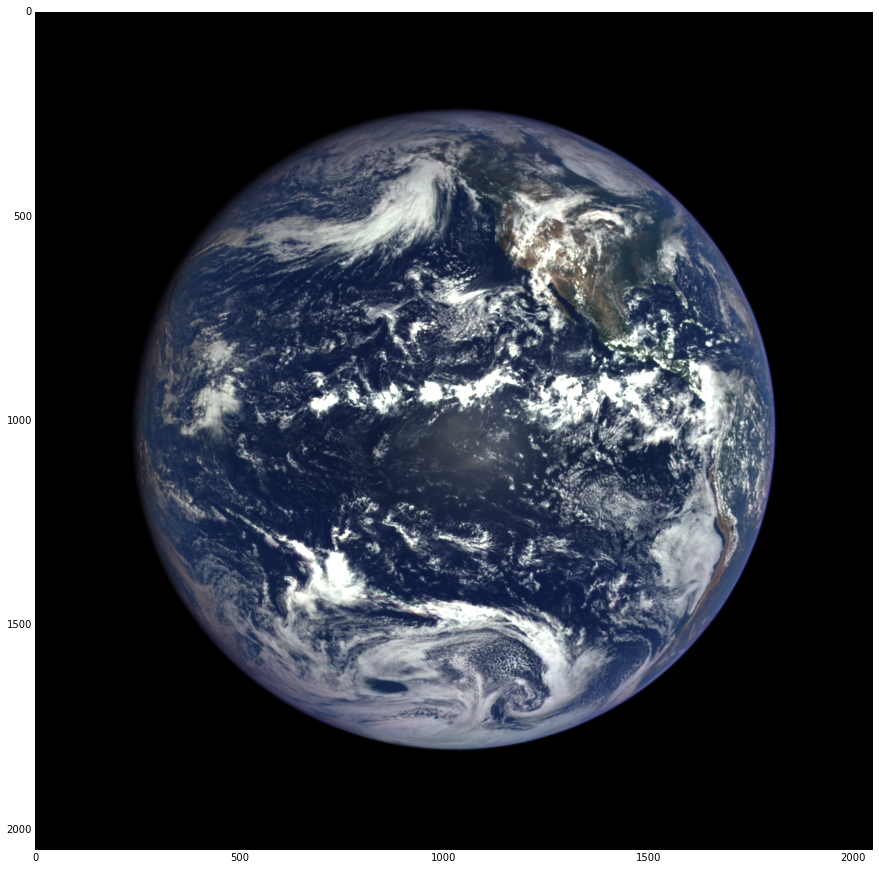

In [20]:
# Select three bands to use as RGB
red_band = img['Band680nm']
green_band = img['Band551nm']
blue_band = img['Band443nm']

def get_image(band):
    # For some reason there are some infinite values in the image, reset those to 0.
    img = np.ma.fix_invalid(np.array(band['Image']), fill_value=0)

    # The image coordinates are a little bit wierd, this fixes them so north is up:
    img = np.fliplr(scipy.ndimage.interpolation.rotate(img, -90, reshape=False))
    return img

def build_rgb(red, green, blue):
    # Apply some simple colour correction
    green *= 0.90
    red *= 1.25
    # Normalise the image to a floating point 0-1 range, and stack the images into a 3D array
    max_value = max(red.max(), green.max(), blue.max())
    rgb = np.dstack((red/max_value, green/max_value, blue/max_value))
    # Exposure correction:
    rgb = np.clip(rgb * 1.8, 0, 1)
    return rgb

figsize(15, 25)
plt.imshow(build_rgb(get_image(red_band), get_image(green_band), get_image(blue_band)))